In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle

In [84]:
df = pd.read_csv('data/train.csv')
df.shape

(1628, 29)

In [85]:
df.columns

Index(['Id', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill',
       'Behaviour'],
      dtype='object')

### Feature Engineering

In [86]:
def extract_feature(df_input):
    df = df_input.copy()
    df['PropWkngYrsToCompanies'] = pd.cut((df.TotalWorkingYears / (df.NumCompaniesWorked+1)),[-1,2,4,6,8,np.inf], labels=[1,2,3,4,5]).astype('int64')
    df['PropCurrMgrCompYears'] = df.YearsWithCurrManager / (df.YearsAtCompany+1)
    df['PropCurrRoleCompYears'] = df.YearsInCurrentRole / (df.YearsAtCompany+1)
    #df['AgeCut'] = pd.cut(df.Age,bins = [0,25,35,50,np.inf], labels= [1,2,3,4]).astype('int64')
    df['Stocks'] = df.StockOptionLevel.apply(lambda x: 0 if x == 0 else 1)
    cols_to_drop = [
                'Id',
                'Behaviour', 
                'Gender',
                'Education',
                'Department',
                'StockOptionLevel',
                #'Age',
                'PerformanceRating',
                'TrainingTimesLastYear', 
                'YearsInCurrentRole', 
                'YearsSinceLastPromotion', 
                'YearsWithCurrManager',
                'NumCompaniesWorked',
                'TotalWorkingYears',
                'PercentSalaryHike',
                'MaritalStatus',
                'EducationField',
                'YearsAtCompany'
                ]
    df.drop(cols_to_drop, inplace = True, axis = 1)
    print('Columns Dropped : {}'.format(cols_to_drop))
    print('Columns in DataFrame: {}'.format(df.columns.to_list()))
    return df

In [87]:
df_cleaned = extract_feature(df)

Columns Dropped : ['Id', 'Behaviour', 'Gender', 'Education', 'Department', 'StockOptionLevel', 'PerformanceRating', 'TrainingTimesLastYear', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumCompaniesWorked', 'TotalWorkingYears', 'PercentSalaryHike', 'MaritalStatus', 'EducationField', 'YearsAtCompany']
Columns in DataFrame: ['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'EmployeeNumber', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MonthlyIncome', 'OverTime', 'CommunicationSkill', 'PropWkngYrsToCompanies', 'PropCurrMgrCompYears', 'PropCurrRoleCompYears', 'Stocks']


### Preprocessing and Model Building Init

In [88]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.shape

(1000, 16)

In [89]:
df_X = df_cleaned.drop(['Attrition'], axis = 1).copy()
df_y = df_cleaned[['Attrition']].copy()

In [90]:
object_type = df_X.select_dtypes(include='object').columns
object_type

numerical_type = df_X.select_dtypes(exclude='object').columns
numerical_type

cat_cols = []
for c in object_type:
    cat_cols.append(df_X.columns.to_list().index(c))
    
cat_cols

[1, 6, 9]

In [91]:
df_X.head()

,Age,BusinessTravel,DistanceFromHome,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,CommunicationSkill,PropWkngYrsToCompanies,PropCurrMgrCompYears,PropCurrRoleCompYears,Stocks
0,30,Non-Travel,2,571,3,3,Laboratory Technician,4,2564,No,4,5,0.583333,0.583333,0
1,36,Travel_Rarely,12,1614,3,3,Manufacturing Director,3,4663,Yes,2,1,0.250000,0.500000,1
2,55,Travel_Rarely,2,842,3,3,Sales Executive,4,5160,No,5,2,0.300000,0.700000,0
3,39,Travel_Rarely,24,2014,1,3,Research Scientist,4,4108,No,4,2,0.875000,0.875000,0
4,37,Travel_Rarely,3,689,3,3,Manufacturing Director,3,9434,No,1,3,0.727273,0.636364,1


In [92]:
df_X.dtypes

Age                          int64
BusinessTravel              object
DistanceFromHome             int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
JobInvolvement               int64
JobRole                     object
JobSatisfaction              int64
MonthlyIncome                int64
OverTime                    object
CommunicationSkill           int64
PropWkngYrsToCompanies       int64
PropCurrMgrCompYears       float64
PropCurrRoleCompYears      float64
Stocks                       int64
dtype: object

In [93]:
df_X_cat = pd.get_dummies(df_X.iloc[:,cat_cols], drop_first=True)

In [94]:
df_X_num = pd.get_dummies(df_X.loc[:, numerical_type])

In [95]:
df_X_final = pd.concat((df_X_num, df_X_cat), axis= 1)

In [96]:
final_cols = df_X_final.columns.values

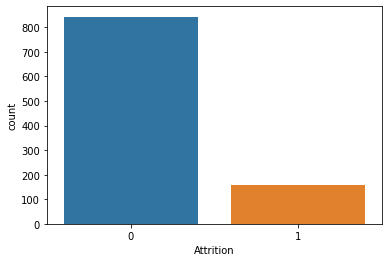

In [97]:
sns.countplot(df_y.Attrition)

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
#df_X_final = df_X_final.values
#df_y = df_y.values
X_train,X_test,y_train,y_test = train_test_split(df_X_final, df_y, test_size=0.10, random_state = 0, stratify=df_y)

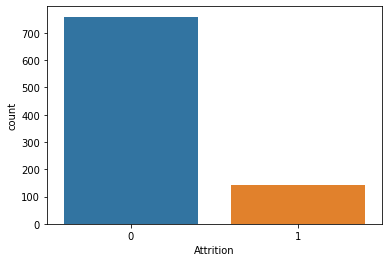

In [309]:
sns.countplot(y_train.Attrition)

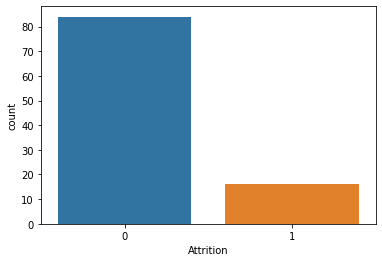

In [310]:
sns.countplot(y_test.Attrition)

In [311]:
X_train,X_test,y_train,y_test = X_train.values,X_test.values,y_train.values,y_test.values

In [312]:
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [313]:
#oversampler = SMOTE(sampling_strategy= 0.7)
oversampler_1 = RandomOverSampler(sampling_strategy=0.5)
#oversampler = SVMSMOTE(sampling_strategy= 0.8)
oversampler_2 = ADASYN(sampling_strategy= 0.8)
#undersampler = RandomUnderSampler(sampling_strategy=0.8)
X_train, y_train = oversampler_1.fit_resample(X_train, y_train)
X_train, y_train = oversampler_2.fit_resample(X_train, y_train)
#X_train, y_train = undersampler.fit_resample(X_train, y_train)


# oversampler=SMOTE(random_state=11, k_neighbors= 3)
# X_train, y_train = oversampler.fit_sample(X_train,y_train)



In [314]:
y_train, y_test = y_train.ravel(), y_test.ravel()

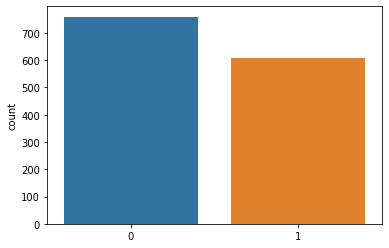

In [315]:
sns.countplot(y_train)

In [316]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

### Building A few Models with CV

In [317]:
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats=3, random_state=1)

In [321]:
gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': [50,70,100,200,300,400,500,1000],
            'max_features': ['log2','auto','None'],
            'oob_score': [True, False]
        },
        cv=cv, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_features': 'auto', 'n_estimators': 400, 'oob_score': True}
0.9899967329700652


In [324]:
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['log2','auto','None']
        },
        cv=cv, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'best'}
0.8938279362712666


In [325]:
gsc = GridSearchCV(
        estimator=AdaBoostClassifier(),
        param_grid={
            'n_estimators': [20,40,50,60,80,100],
            'learning_rate': [0.5,0.7,0.8,0.9,1,1.2,1.5,2]
        },
        cv=cv, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 1.5, 'n_estimators': 100}
0.9317567363359683


In [326]:
scores = cross_val_score(RandomForestClassifier(n_estimators = 400, oob_score = True), X_train, y_train, scoring='roc_auc', cv=cv)
scores

array([0.98457722, 0.99521531, 0.99005002, 0.98355263, 0.99191184,
       0.98511648, 0.98779361, 0.99671053, 0.9843682 , 0.9929975 ,
       0.98290552, 0.98817421, 0.99706394, 0.98708678, 0.99563022])

In [327]:
scores = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_features = 'log2', splitter='best'), X_train, y_train, scoring='roc_auc', cv=cv)
scores

array([0.87926014, 0.86488691, 0.87888756, 0.86564811, 0.8992509 ,
       0.87764236, 0.8691007 , 0.8698619 , 0.87973032, 0.91580719,
       0.88583909, 0.86749674, 0.88470531, 0.91431057, 0.90177505])

In [328]:
scores = cross_val_score(AdaBoostClassifier(n_estimators = 100, learning_rate=1.5), X_train, y_train, scoring='roc_auc', cv=cv)
scores

array([0.93793141, 0.92980644, 0.93513484, 0.92502175, 0.93350342,
       0.93825496, 0.92252066, 0.94307308, 0.90713354, 0.93616328,
       0.95750647, 0.93649413, 0.92964332, 0.90615485, 0.9380089 ])

In [329]:
def check_model_perf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    print(model.__class__)
    print('-'*50)
    print("True Possitives  :\t{}\nTrue Negatives   :\t{}\nFalse Possitives :\t{}\nFalse Negatives  :\t{}".format(tp,tn,fp,fn))
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print("AUC Score : {}".format(auc_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    sns.lineplot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("Accuracy score: {}".format(metrics.accuracy_score(y_test, predictions)))
    print("="*80)
    print(metrics.classification_report(y_test, predictions))
    return auc_score

In [330]:
scores = dict()

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
--------------------------------------------------
True Possitives  :	6
True Negatives   :	79
False Possitives :	5
False Negatives  :	10
AUC Score : 0.6577380952380952
Accuracy score: 0.85
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        84
           1       0.55      0.38      0.44        16

    accuracy                           0.85       100
   macro avg       0.72      0.66      0.68       100
weighted avg       0.83      0.85      0.84       100



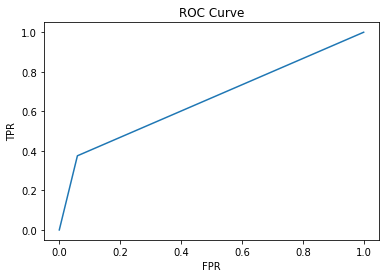

In [349]:
scores['Random Forest'] = check_model_perf(RandomForestClassifier(criterion='entropy', max_features=0.5), X_train, y_train, X_test, y_test)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
--------------------------------------------------
True Possitives  :	5
True Negatives   :	71
False Possitives :	13
False Negatives  :	11
AUC Score : 0.5788690476190477
Accuracy score: 0.76
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        84
           1       0.28      0.31      0.29        16

    accuracy                           0.76       100
   macro avg       0.57      0.58      0.57       100
weighted avg       0.77      0.76      0.77       100



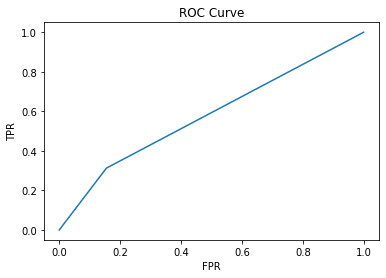

In [350]:
scores['Decision Tree'] = check_model_perf(DecisionTreeClassifier(criterion='entropy', max_features = 0.6, splitter='best'), X_train, y_train, X_test, y_test)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
--------------------------------------------------
True Possitives  :	11
True Negatives   :	76
False Possitives :	8
False Negatives  :	5
AUC Score : 0.7961309523809523
Accuracy score: 0.87
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        84
           1       0.58      0.69      0.63        16

    accuracy                           0.87       100
   macro avg       0.76      0.80      0.77       100
weighted avg       0.88      0.87      0.87       100



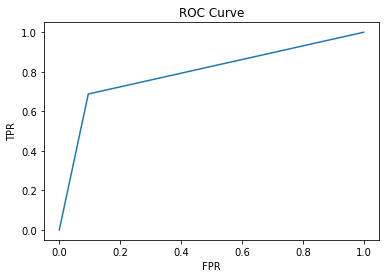

In [386]:
scores['AdaBoost'] = check_model_perf(AdaBoostClassifier(n_estimators = 540, learning_rate=0.6, algorithm='SAMME'), X_train, y_train, X_test, y_test)

In [334]:
pd.DataFrame.from_dict(scores, orient='index', columns=['AUC Score']).sort_values(by=['AUC Score'], ascending=False)

,AUC Score
AdaBoost,0.758929
Random Forest,0.581845
Decision Tree,0.552083


In [335]:
from sklearn import tree

In [266]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
pd.DataFrame(model.feature_importances_, index= final_cols).sort_values(by=0, ascending=False)

,0
OverTime_Yes,0.133922
Stocks,0.095737
MonthlyIncome,0.080471
PropWkngYrsToCompanies,0.073872
JobInvolvement,0.060200
Age,0.058817
EmployeeNumber,0.053683
DistanceFromHome,0.053216
JobSatisfaction,0.051335
EnvironmentSatisfaction,0.045432


In [336]:
model = AdaBoostClassifier(n_estimators = 100, learning_rate=1.5)
model.fit(X_train, y_train)
pd.DataFrame(model.feature_importances_, index= final_cols).sort_values(by=0, ascending=False)

,0
MonthlyIncome,0.23
EmployeeNumber,0.16
PropCurrRoleCompYears,0.08
Age,0.07
DistanceFromHome,0.06
JobInvolvement,0.05
EnvironmentSatisfaction,0.04
JobSatisfaction,0.04
PropCurrMgrCompYears,0.04
JobRole_Sales Executive,0.03


In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
pd.DataFrame(model.feature_importances_, index= final_cols).sort_values(by=0, ascending=False)

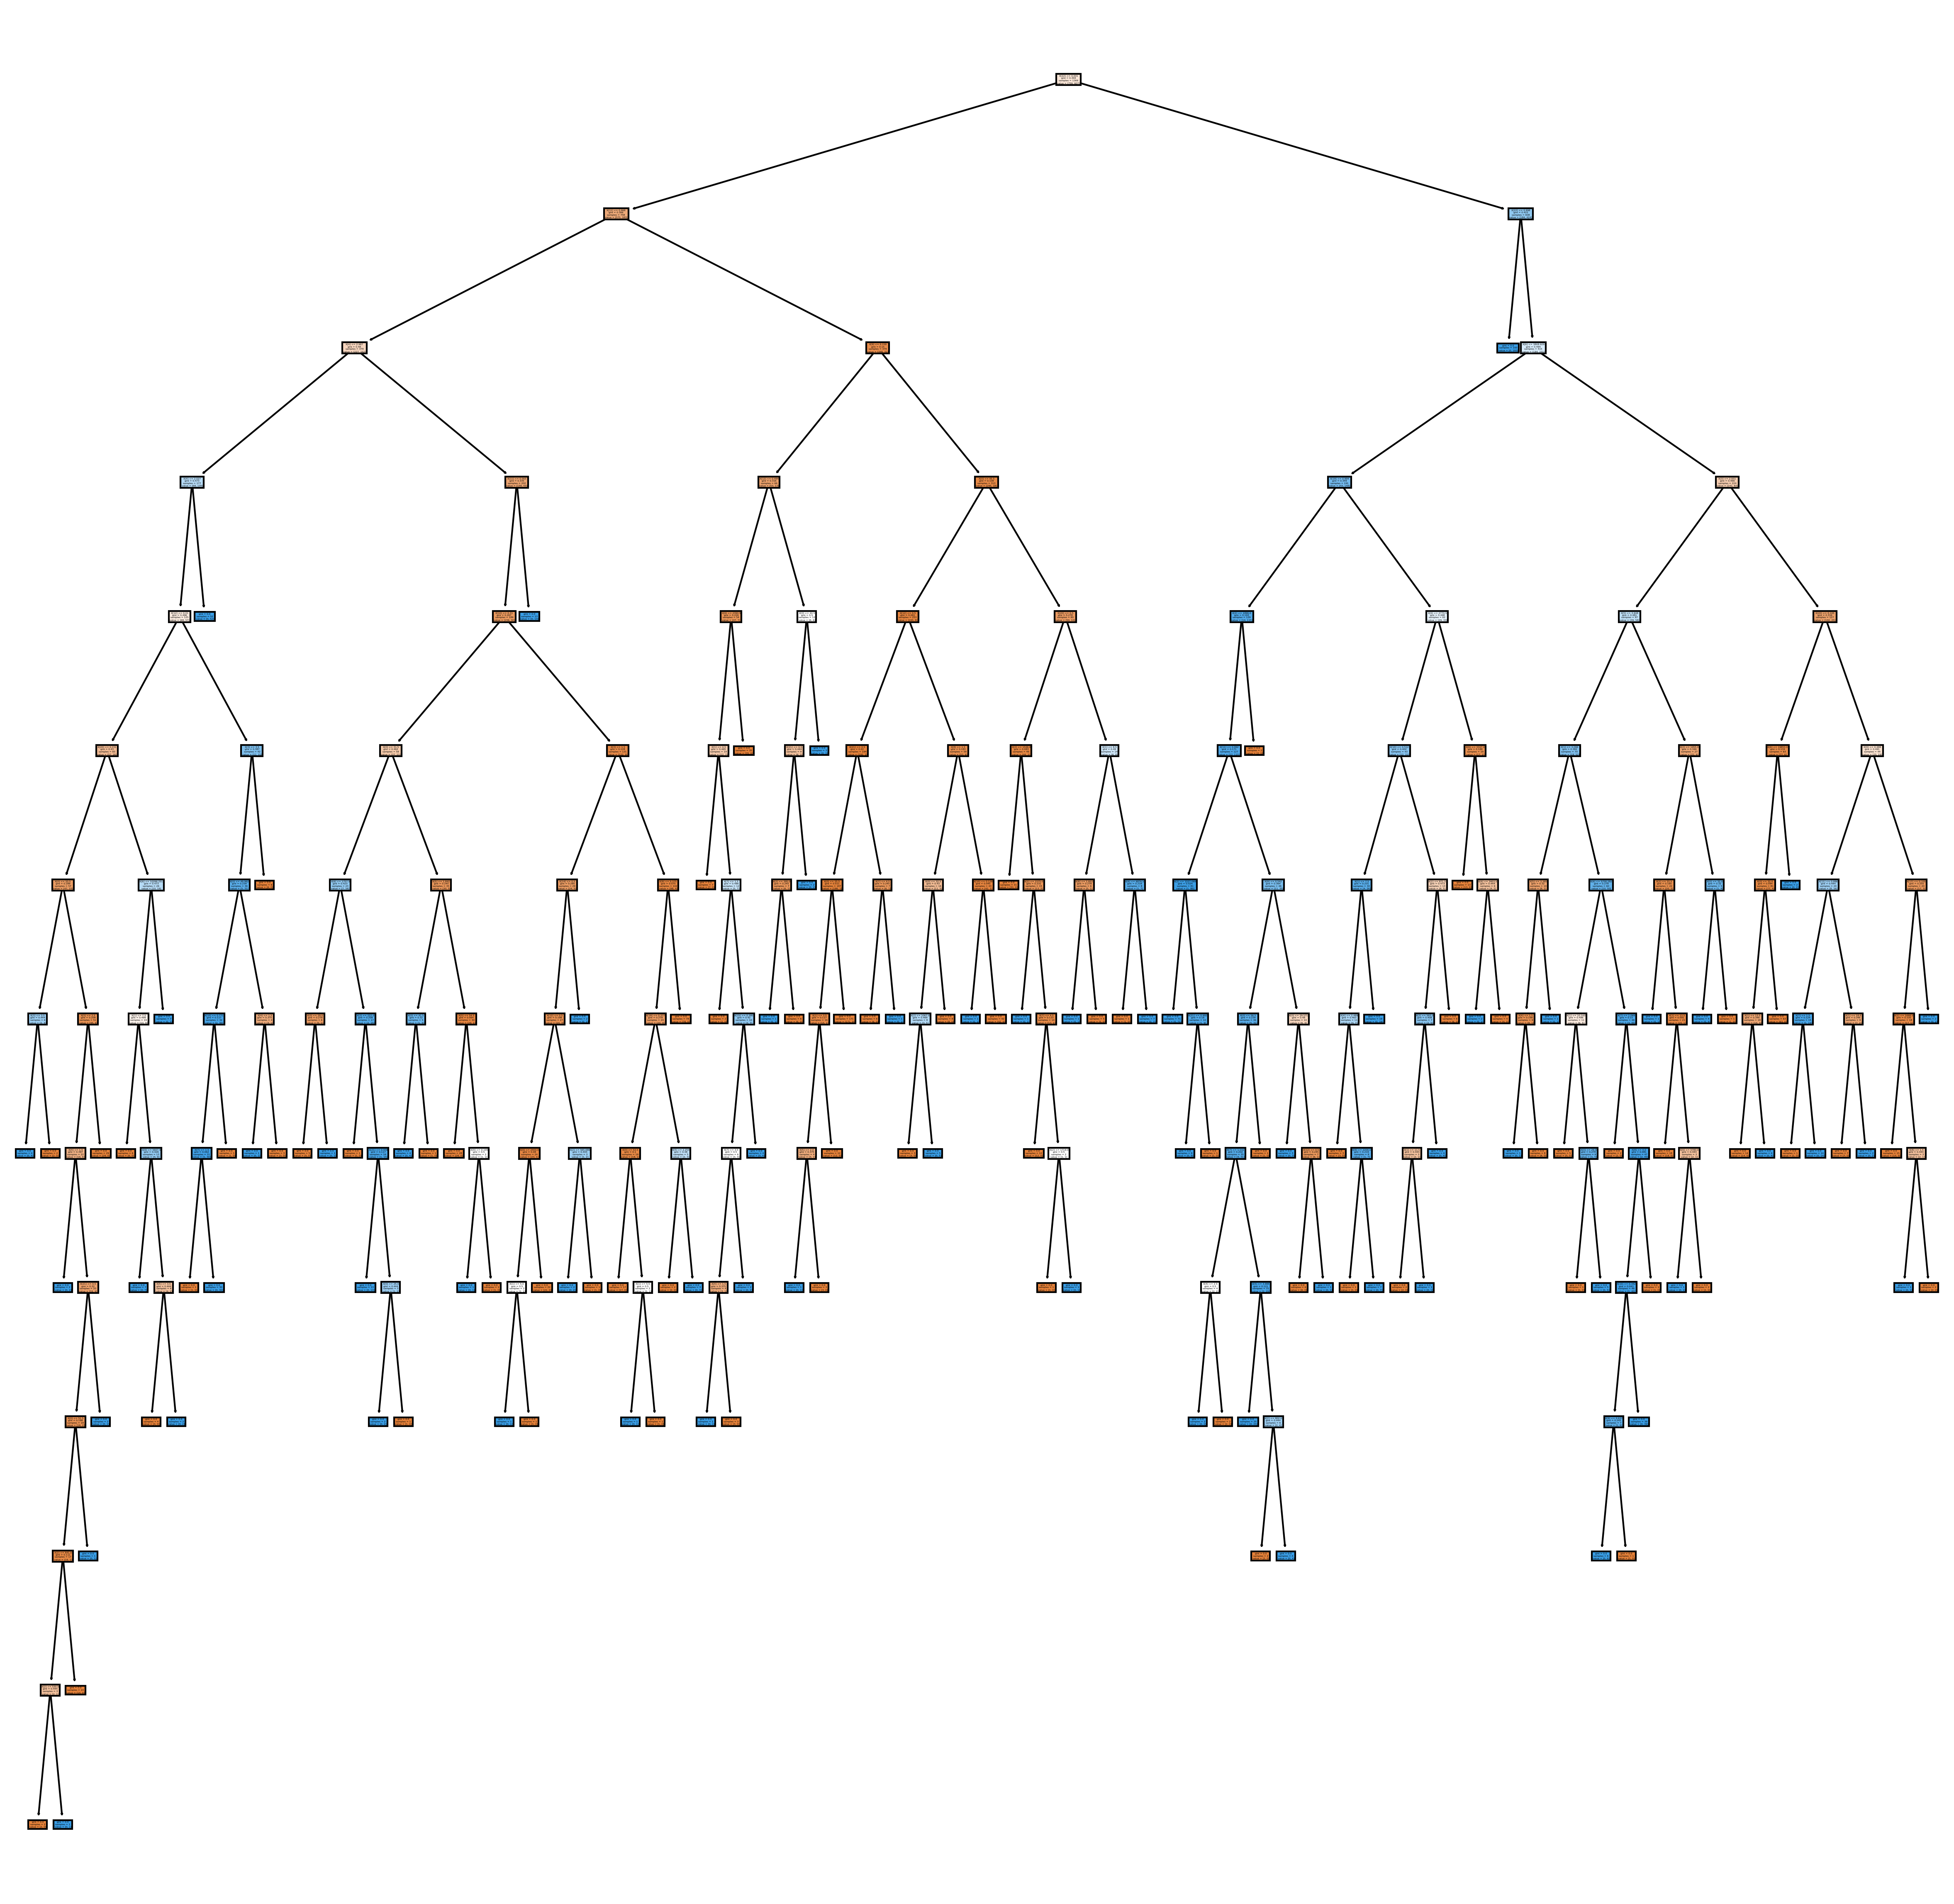

In [273]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=300)
tree.plot_tree(model,
               filled = True);
fig.savefig('imagename.png')

### Models_for_submission

In [151]:
!mkdir models

mkdir: models: File exists


RandomForest

In [311]:
X, y = oversampler.fit_resample(df_X_final, df_y)

In [338]:
model = RandomForestClassifier(n_estimators = 400, oob_score = True)
model.fit(X_train, y_train)
pkl_filename = "models/RandomForestA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [339]:
model = DecisionTreeClassifier(criterion='entropy', max_features = 'log2', splitter='best')
model.fit(X_train, y_train)
pkl_filename = "models/DecisionTreeA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [387]:
model = AdaBoostClassifier(n_estimators = 540, learning_rate=0.6, algorithm='SAMME')
model.fit(X_train, y_train)
pkl_filename = "models/AdaboostA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)